# Average Rating Book Prediction  #

## Introduction ##

 L'objectif de ce projet est de prédire la note moyenne pouvant être obtenue par un livre à base d'informations sur celui-ci. Cette note peut être comprise entre 1 et 5 et peut dépendre de plusieurs facteurs  tels que : 
 - son titre, 
 - son/ses auteur(s) ;
 - son/ses éditeur(s) ;
 - sa langue d'édition ;
 - son nombre de pages ;
 - le nombre de critiques obtenu ;
 - le nombre de personnes lui ayant affecté une note.
 
 Ces différents facteurs pourraient intervenir dans notre prédiction en tant que variables explicatives.

# ANALYSE EXPLORATOIRE DU JEU DE DONNEES
*Dans cette partie nous allons effectuer une analyse exploratoire du jeu de données*

In [2]:
# Chargement des librairies

import os
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import datetime

from datetime import datetime
from statsmodels.formula.api import ols
from scipy.stats import levene, kruskal, shapiro
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV 

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set()

In [3]:
# Chargement du fichier csv dans un DataFrame
books_df = pd.read_csv('books.csv', sep=',', on_bad_lines='skip')

Le fichier csv comportant des lignes incohérentes, nous avons décidé de les supprimer.

In [4]:
# Dimensions du fichier
print('Dimensions du fichier csv : ', books_df.shape)
print('Notre fichier contient',books_df.shape[0],'lignes et',books_df.shape[1],'colonnes')
print('\n======== Visualisation des 5 premières lignes du fichier ========')
books_df.head()

Dimensions du fichier csv :  (11123, 12)
Notre fichier contient 11123 lignes et 12 colonnes

======== Visualisation des 5 premières lignes du fichier ========


bookID                                              title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   
1       2  Harry Potter and the Order of the Phoenix (Har...   
2       4  Harry Potter and the Chamber of Secrets (Harry...   
3       5  Harry Potter and the Prisoner of Azkaban (Harr...   
4       8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2                J.K. Rowling            4.42  0439554896  9780439554893   
3  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
4  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

  language_code    num_pages  ratings_count  text_reviews_count  \
0           eng          652        2095690               27591   
1           eng          870        2153167               29221   
2           eng          352           6333                 244   
3           eng          435        2339585               36325   
4           eng         2690          41428                 164   

  publication_date        publisher  
0        9/16/2006  Scholastic Inc.  
1         9/1/2004  Scholastic Inc.  
2        11/1/2003       Scholastic  
3         5/1/2004  Scholastic Inc.  
4        9/13/2004       Scholastic

In [5]:
# Informations sur le DataFrame
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [6]:
# Recherche valeurs manquantes
books_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [7]:
# Recherche lignes dupliquées
books_df.duplicated().sum()

0

Après une première analyse du DataFrame, nous pouvons effectuer les remarques suivantes :
 - Nous avons des variables catégorielles (type : object) et numériques (types : int64 et float64) ;
 - Les variables catégorielles sont: title, authors, language_code, publication_date, publisher ;
 - Les variables numériques sont: bookID, average_rating, num_pages, ratings_count, text_review_count.
 - Nous n'avons pas de valeurs manquantes ;
 - Nous n'avons pas de lignes dupliquées.
 
 La variable cible (average_rating) est une variable numérique et continue donc nous pouvons dire que nous faisons face à un problème de regression.

In [8]:
explo_report = pd.read_excel('Exploration_report.xlsx')
d = {'Variable':explo_report.iloc[1:,0],'Description': explo_report.iloc[1:,1]}
description_df = pd.DataFrame(d)
description_df.set_index('Variable',inplace=True)
pd.options.display.max_colwidth = 100
description_df
description_df.T

Variable                                            title  \
Description  The name under which the book was published.   

Variable                                                                            authors  \
Description  The names of the authors of the book. Multiple authors are delimited by \n“/”.   

Variable                                        average_rating  \
Description  The average rating of the book received in total.   

Variable                                                                                               isbn  \
Description  Another unique number to identify the book, known as the International \nStandard Book Number.   

Variable                                                                           isbn13  \
Description  A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.   

Variable                                                                                   language_code  \
Description  : Indicates the primary language of the book. For instance, “eng” is\nstandard for English.   

Variable                                  num_pages  \
Description  The number of pages the book contains.   

Variable                                      ratings_count  \
Description  The total number of ratings the book received.   

Variable                                              text_reviews_count  \
Description  The total number of written text reviews the book received.   

Variable                      publication_date  \
Description   The date the book was published.   

Variable                           publisher  
Description  The name of the book publisher.

 Les champs bookID, isbn et isbn13 n'auront pas d'influence sur la note prédite, car unique pour chaque livre. Nous avons décidé de les supprimer.

In [9]:
books_df = books_df.drop(["isbn","isbn13","bookID"], axis = 1)

In [10]:
books_df = books_df.rename({'  num_pages' : 'num_pages'}, axis=1)

In [11]:
books_df['publication_date'] = pd.to_datetime(books_df['publication_date'], errors='coerce')

In [12]:
books_df=books_df.dropna(subset=['publication_date'])

In [13]:
books_df['Year']=books_df['publication_date'].dt.year

In [14]:
books_df['Year'] = books_df['publication_date'].dt.strftime('%Y')
books_df['Month'] = books_df['publication_date'].dt.strftime('%B')
books_df['Day'] = books_df['publication_date'].dt.strftime('%d')
books_df['Weekly_Day'] = books_df['publication_date'].dt.strftime('%A')

In [15]:
books_df=books_df.drop(['publication_date','Day'], axis=1)

In [16]:
books_df = books_df[books_df['num_pages'] != 0]
books_df = books_df[books_df['average_rating'] != 0]
books_df = books_df[books_df['ratings_count'] != 0]

In [17]:
# Description statistique variables numériques
books_df.describe()

average_rating     num_pages  ratings_count  text_reviews_count
count    10966.000000  10966.000000   1.096600e+04        10966.000000
mean         3.943314    339.006566   1.819614e+04          549.679373
std          0.294543    240.181443   1.132815e+05         2594.200133
min          1.000000      1.000000   1.000000e+00            0.000000
25%          3.780000    197.000000   1.130000e+02           10.000000
50%          3.960000    302.000000   7.820000e+02           48.000000
75%          4.140000    416.000000   5.139500e+03          244.000000
max          5.000000   6576.000000   4.597666e+06        94265.000000

In [18]:
# Description statistique variables catégorielles
books_df.describe(include='object')

title       authors language_code publisher   Year  \
count                    10966         10966         10966     10966  10966   
unique                   10209          6544            26      2247     86   
top     The Brothers Karamazov  Stephen King           eng   Vintage   2006   
freq                         9            40          8786       318   1668   

            Month Weekly_Day  
count       10966      10966  
unique         12          7  
top     September    Tuesday  
freq         1266       3883

### Analyse des variables numériques

#### Distribution

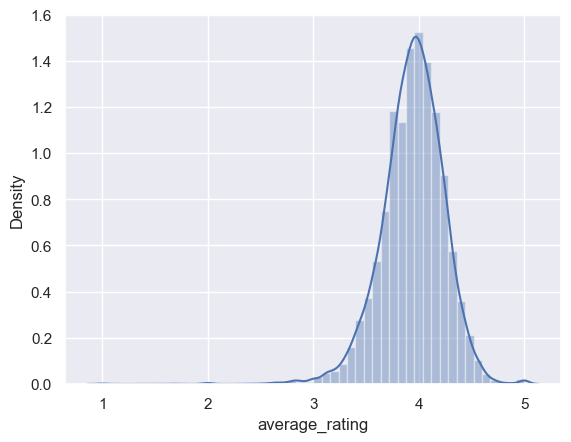

In [19]:
for col in books_df.select_dtypes('float'):
  plt.figure()
  sns.distplot(books_df[col])

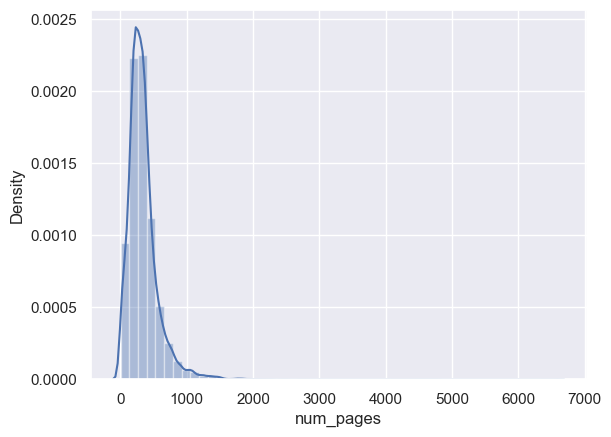

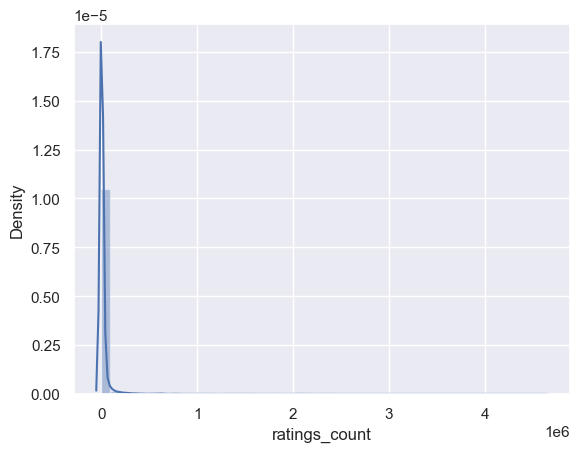

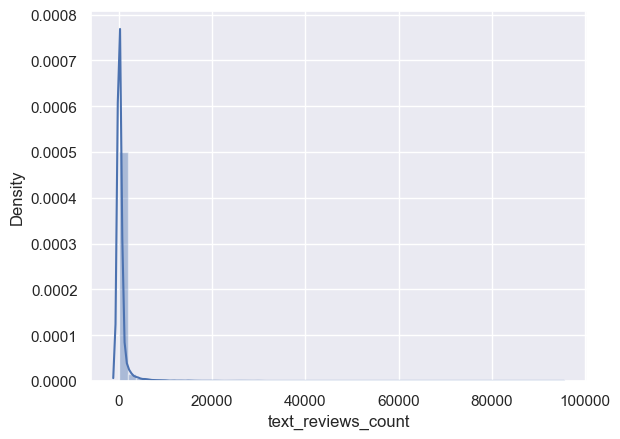

In [20]:
for col in books_df.select_dtypes('int'):
  plt.figure()
  sns.distplot(books_df[col])

#### Boîte à moustache

In [21]:
fig=px.box(books_df, x=books_df["num_pages"])
fig.show()

In [22]:
fig=px.box(books_df, x=books_df["text_reviews_count"])
fig.show()

In [23]:
fig=px.box(books_df, x=books_df["ratings_count"])
fig.show()

In [24]:
fig=px.box(books_df, x=books_df["average_rating"])
fig.show()

A la suite de notre analyse des variables quantitatives, dans l'objectif d'optimiser notre apprentissage, nous avons imposé des critères à notre jeu de données. Ces critères sont les suivants :
- num_pages : ne dépasse pas 1.500 pages ;
- text_reviews_count : ne dépasse 20.000 commentaires ;
- ratings_count : ne dépasse pas 800.000 votes ;
- average_rating : est compris entre 2.5 et 4.7.

En effet ces critères correspondent à une volonté de cohérence de notre jeu de données.

In [25]:
books_df = books_df[books_df['num_pages'] <= 1500]
books_df = books_df[books_df['text_reviews_count'] <= 20000]
books_df = books_df[books_df['ratings_count'] <= 800000]
books_df = books_df[books_df['average_rating'] >= 2.5 ]
books_df = books_df[books_df['average_rating'] <= 4.7 ]

In [26]:
books=books_df.copy()

#### Nuages de points

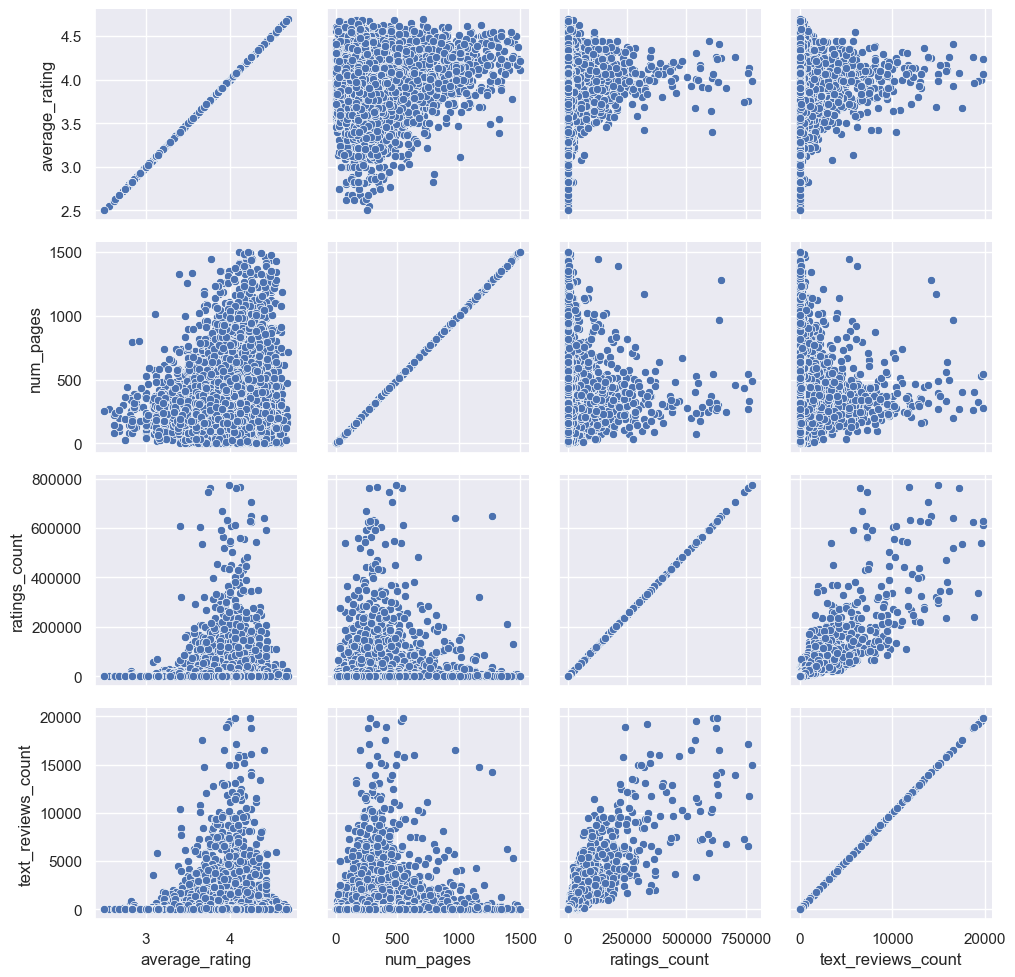

In [27]:
numerical_variables = ['average_rating','num_pages','ratings_count','text_reviews_count']
books_df_numerical = books[numerical_variables]
books_df_categorical = books_df.drop(numerical_variables, axis = 1)
g = sns.PairGrid(books_df_numerical)
g.map(sns.scatterplot)

#### TEST DE SHAPIRO:
Ce test est réalisé pour vérifier si une variable suit une loi normale

In [28]:
#test de shapiro
results_list = []

for var in numerical_variables:
    statistic, pvalue = shapiro(books[var])
    results_list.append({'variable': var, 'statistic': statistic, 'pvalue': pvalue})

results_df = pd.concat([pd.DataFrame([entry]) for entry in results_list], ignore_index=True)
display(results_df)

variable  statistic        pvalue
0      average_rating   0.985071  3.593167e-32
1           num_pages   0.893277  0.000000e+00
2       ratings_count   0.256934  0.000000e+00
3  text_reviews_count   0.321613  0.000000e+00

La pvalue de chacune des variables numériques étant inférieure à 0.05, on peut sans aucun doute attester qu'elles ne suivent pas une loi normale. Nous utiliserons donc le Test de Spearman pour évaluer les corrélation entre elles.

#### Heatmap de Spearman 

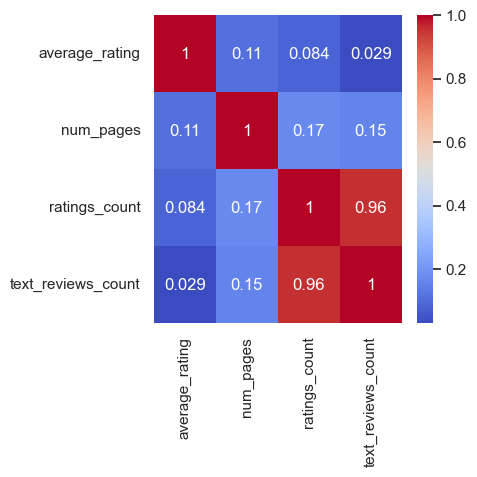

In [29]:
cor = books_df_numerical.corr(method = 'spearman')

fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(data=cor, annot= True,ax=ax,cmap='coolwarm');

### Analyse des variables catégorielles

##### Traitement de la colonne authors

In [30]:
# Exctraction des auteurs
books_df_split=books['authors'].str.split('/', expand=True)
all_none_columns=[col for col in books_df_split.columns if books_df_split[col].isna().sum()==len(books_df_split)-1]
books_df_split.drop(columns=all_none_columns, inplace=True)
books=pd.concat([books, books_df_split], axis=1)

In [31]:
for i in range(books_df_split.shape[1]):
    books.rename(columns={i:'authors_'+str(i)}, inplace=True)

In [32]:
books=books.drop('authors', axis=1)

In [33]:
no_authors_cat_list=['title','language_code','publisher', 'Year', 'Month','Weekly_Day']
df_cat_without_authors=books_df_categorical[no_authors_cat_list]

In [34]:
cols_no_authors=df_cat_without_authors.columns

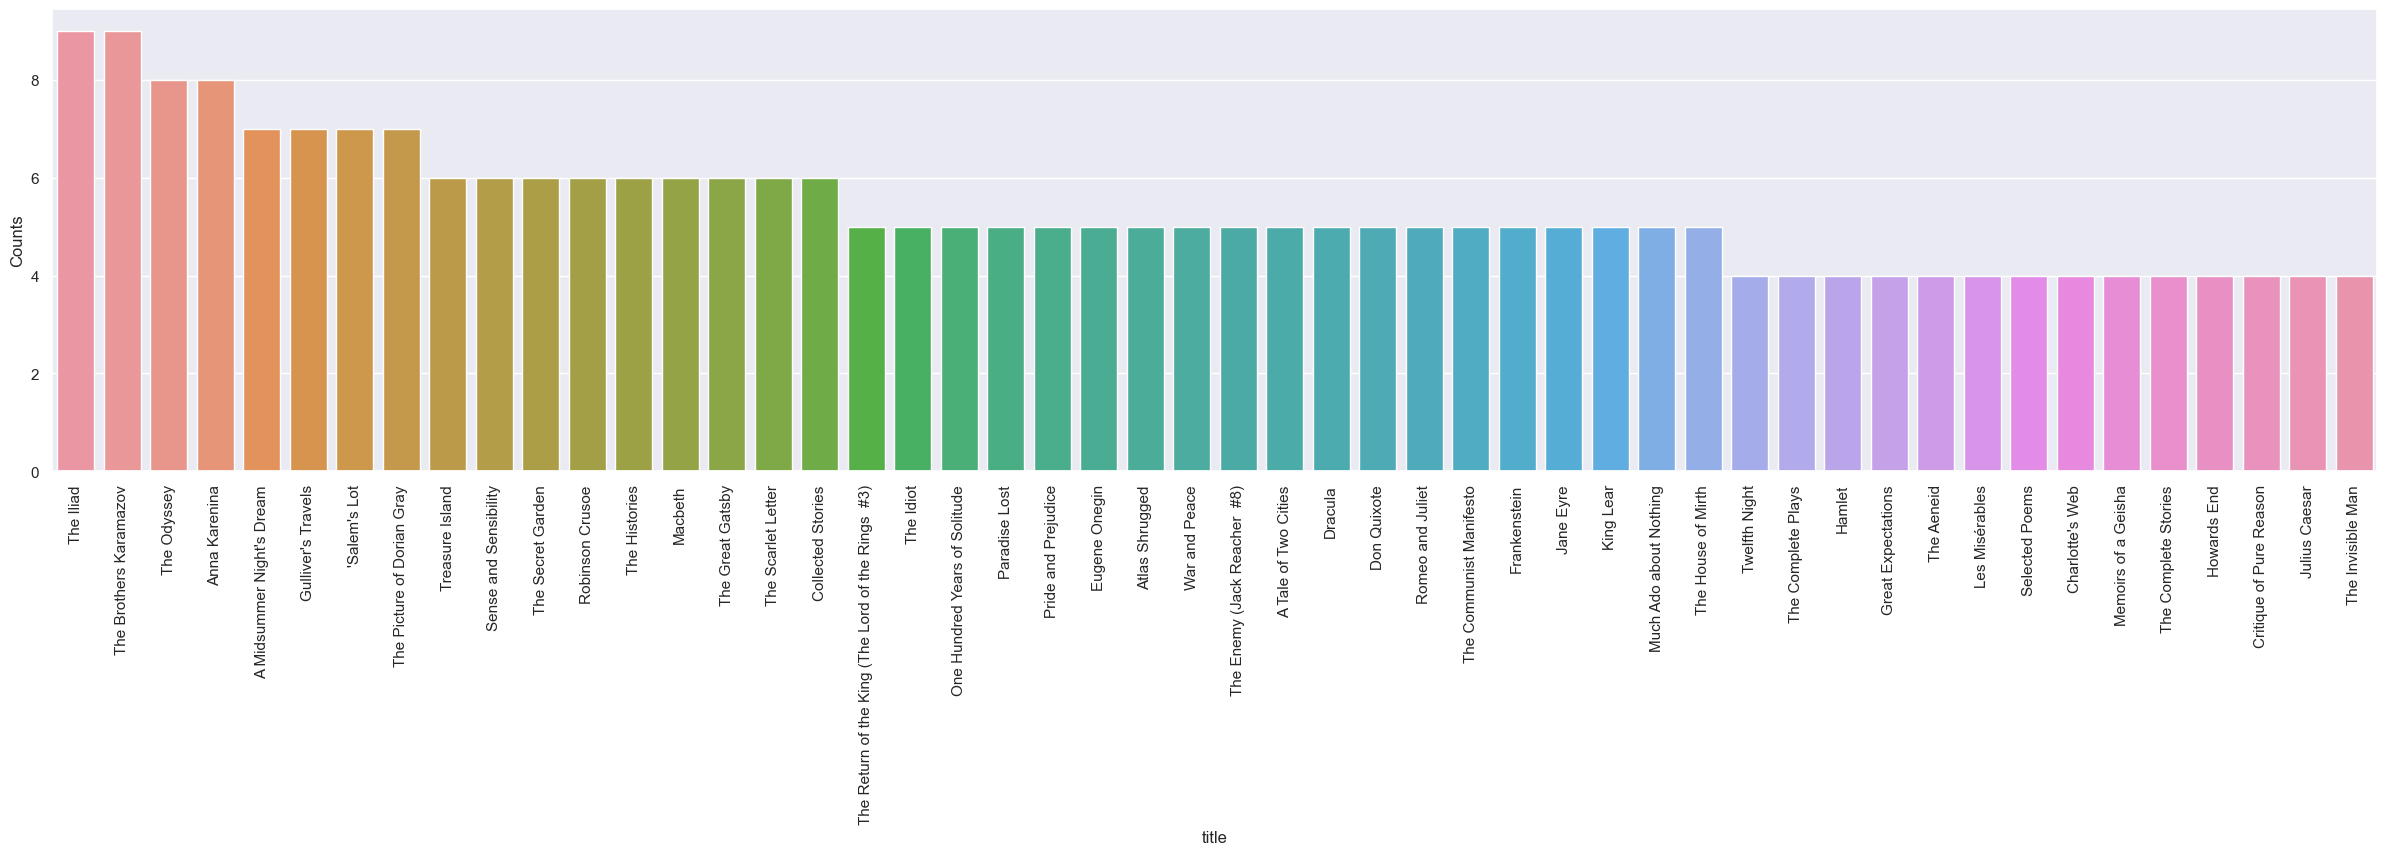

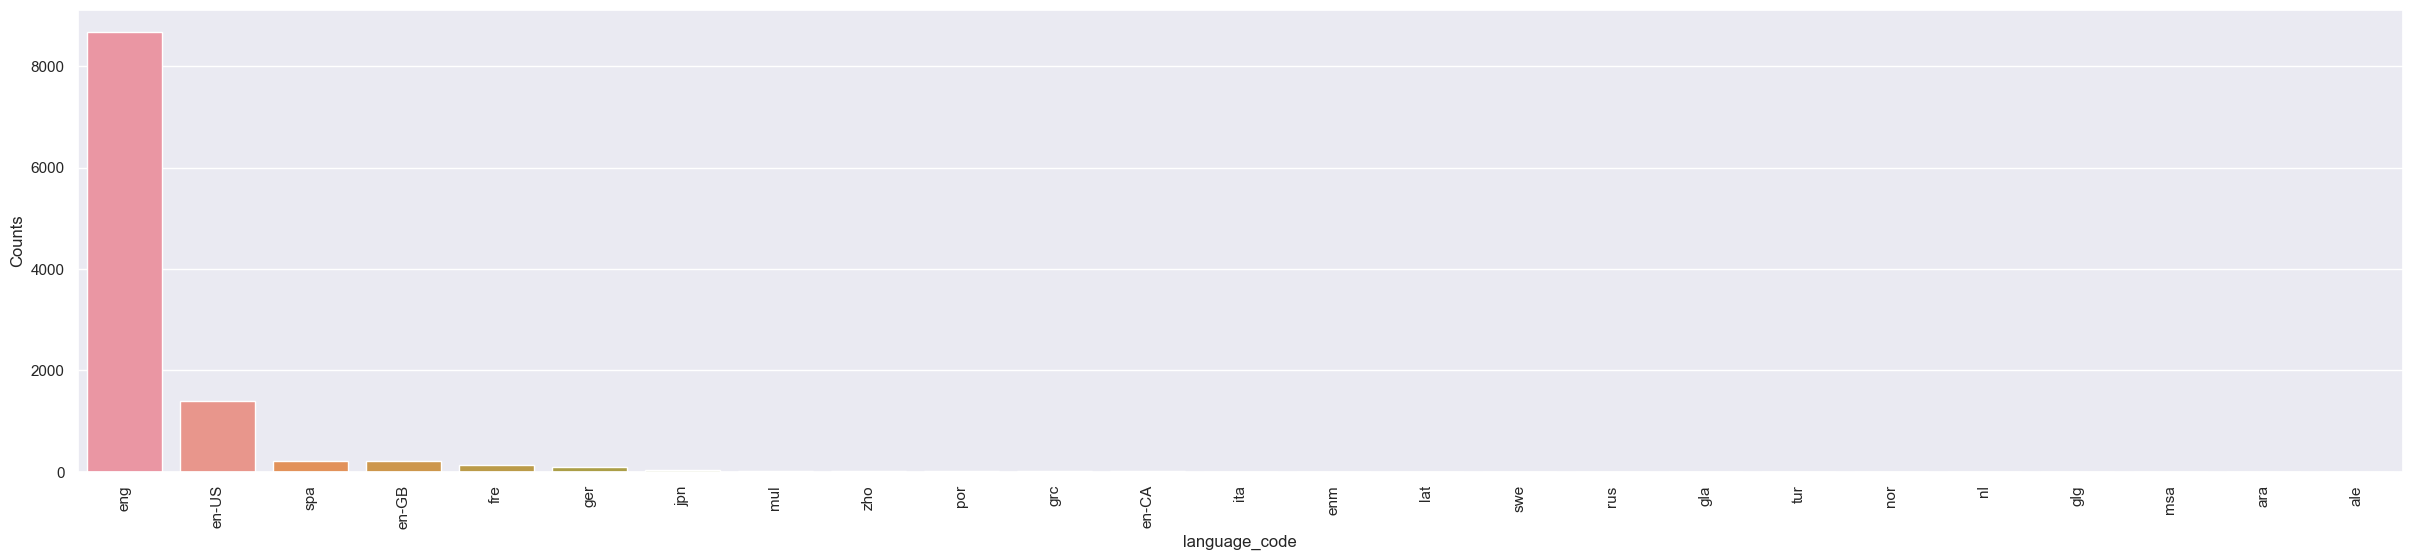

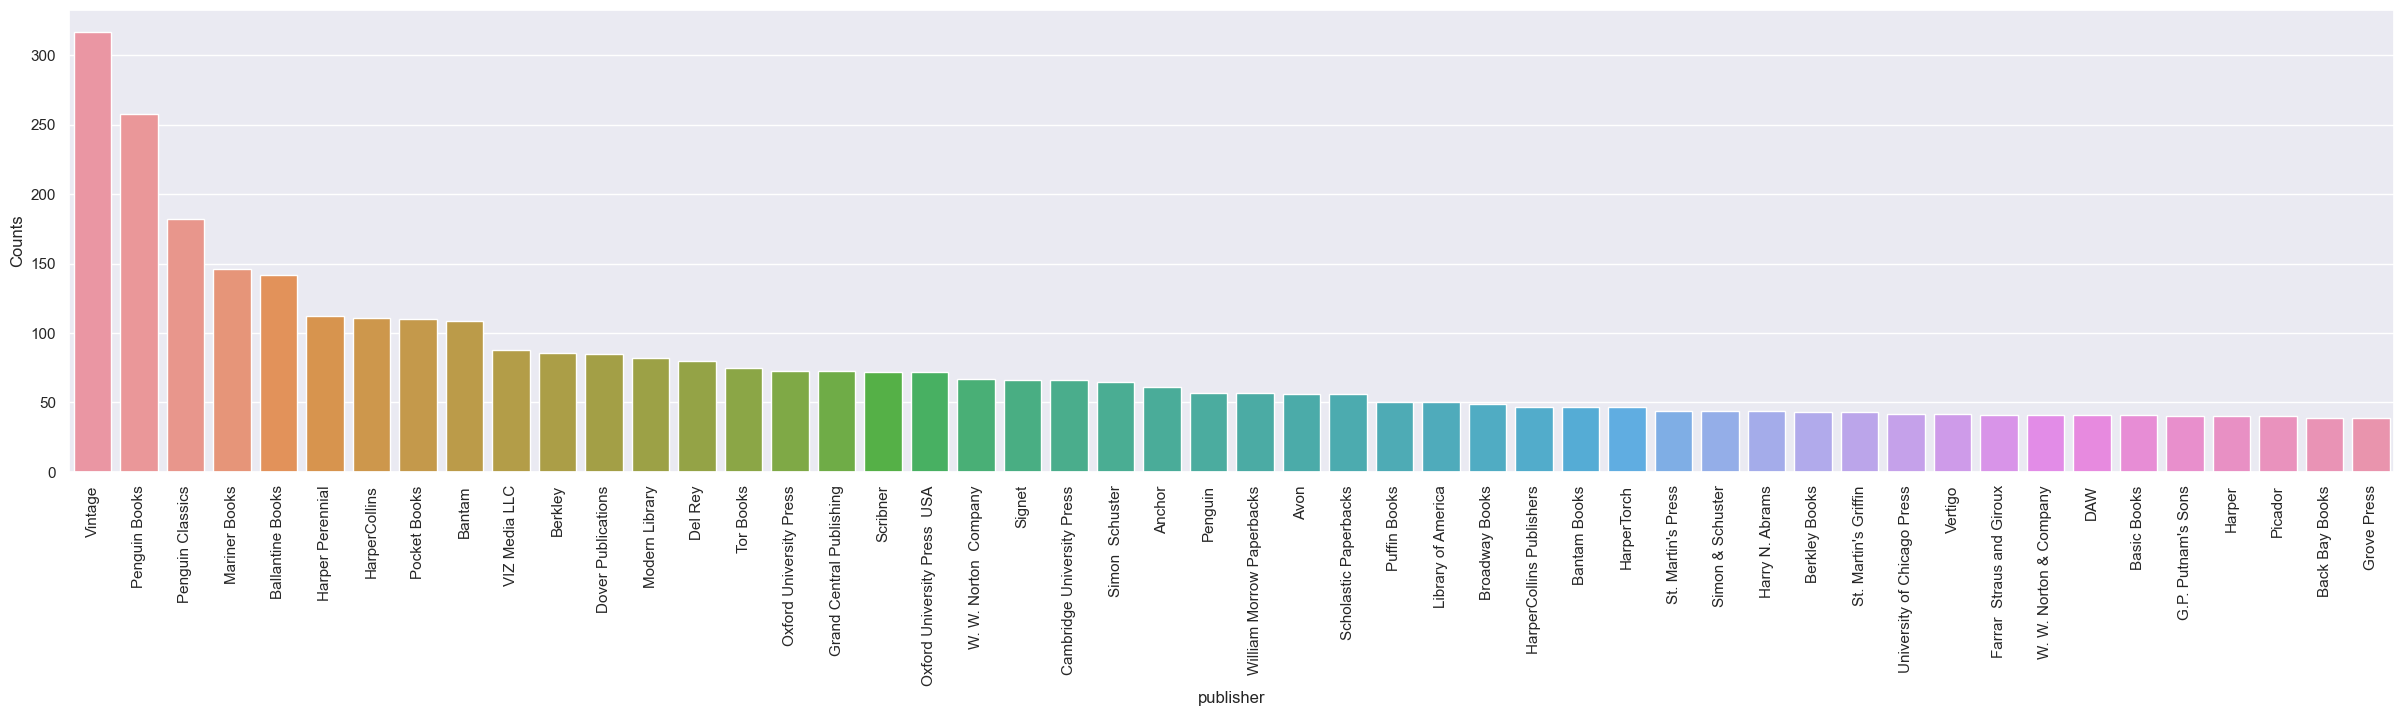

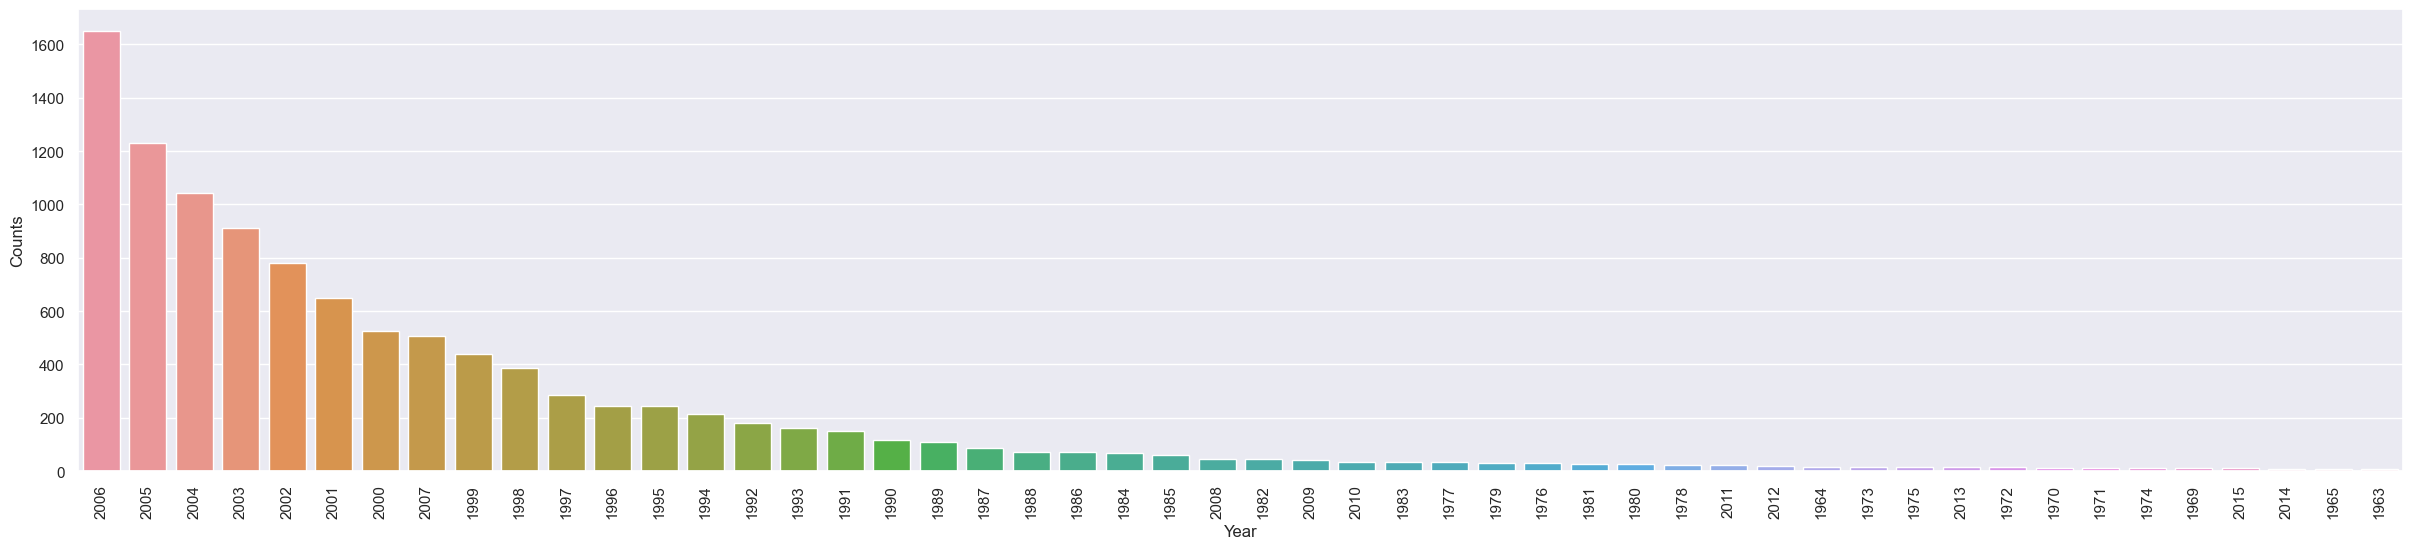

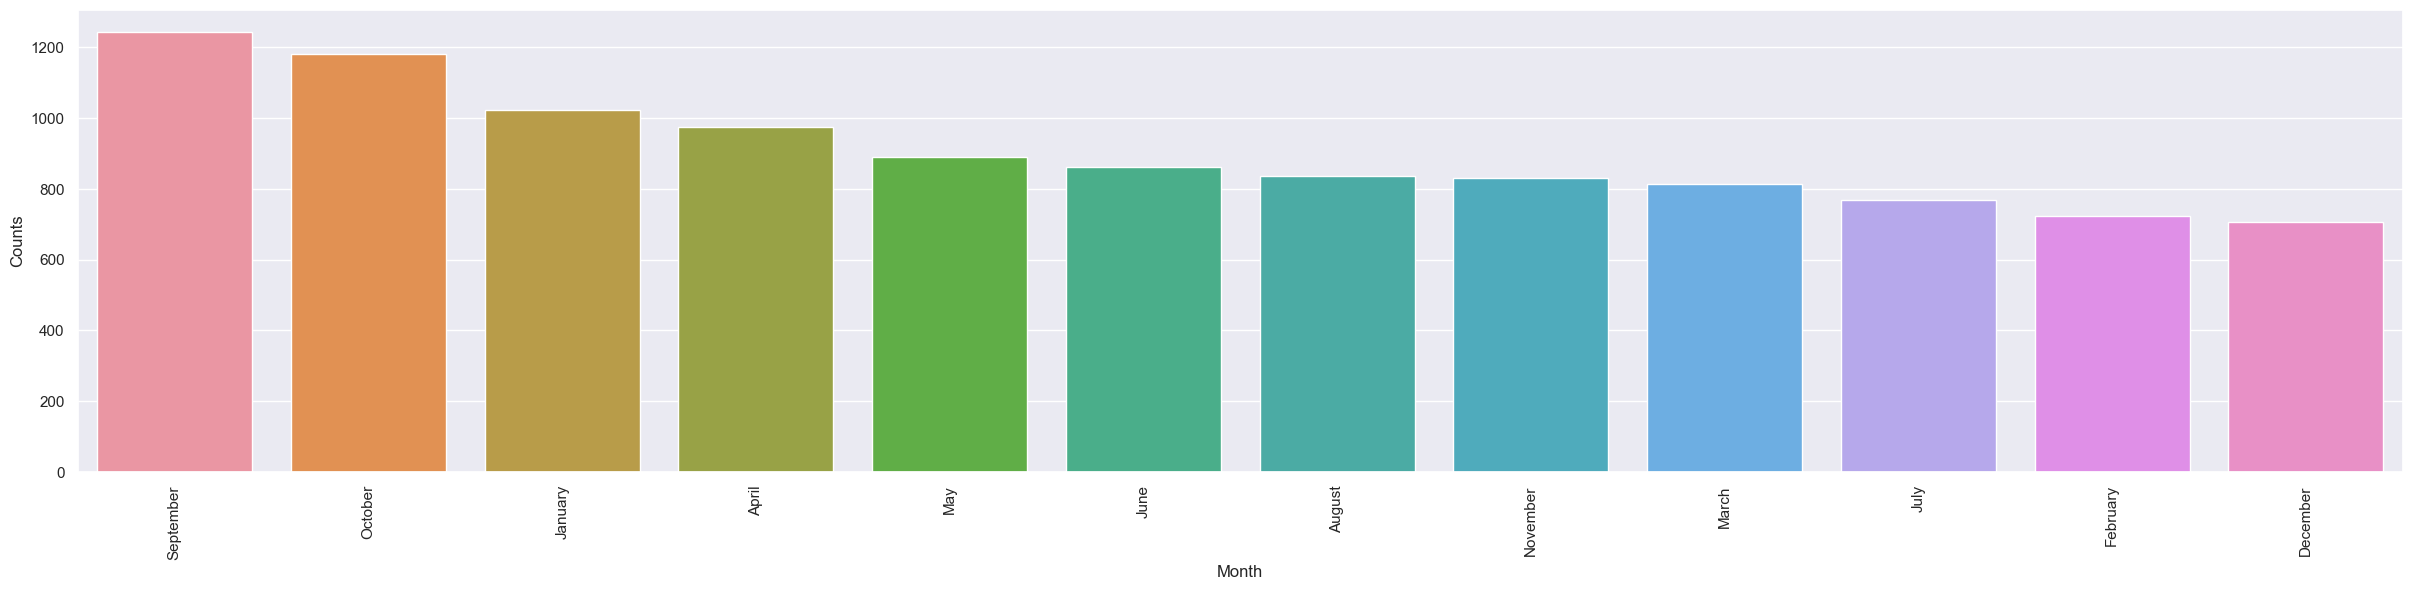

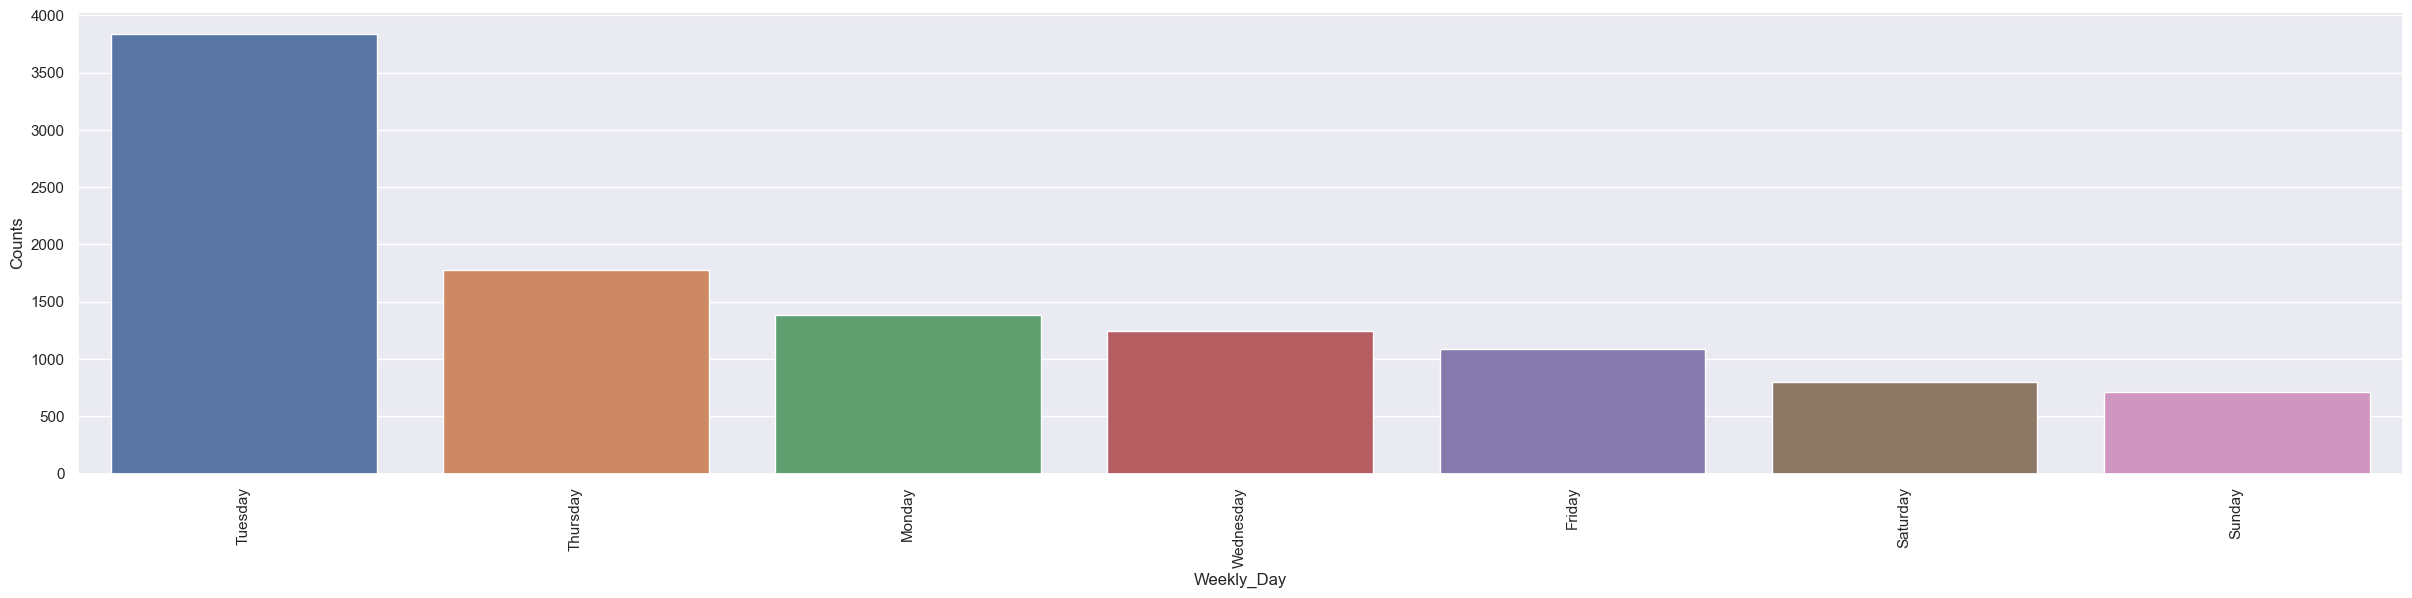

In [35]:
top_n=50
for col in cols_no_authors:
    value_counts=df_cat_without_authors[col].value_counts().head(top_n)
    top_df=pd.DataFrame({col:value_counts.index, 'Counts':value_counts.values})
    top_df=top_df.sort_values(by='Counts',ascending=False)
    plt.figure(figsize=(30,6))
    ax=sns.barplot(data=top_df, x=col, y='Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

In [36]:
fig=px.box(books, x='language_code', y='average_rating')
fig.show() 


In [37]:
fig=px.box(books, x=books["Year"], y='average_rating')
fig.show() 

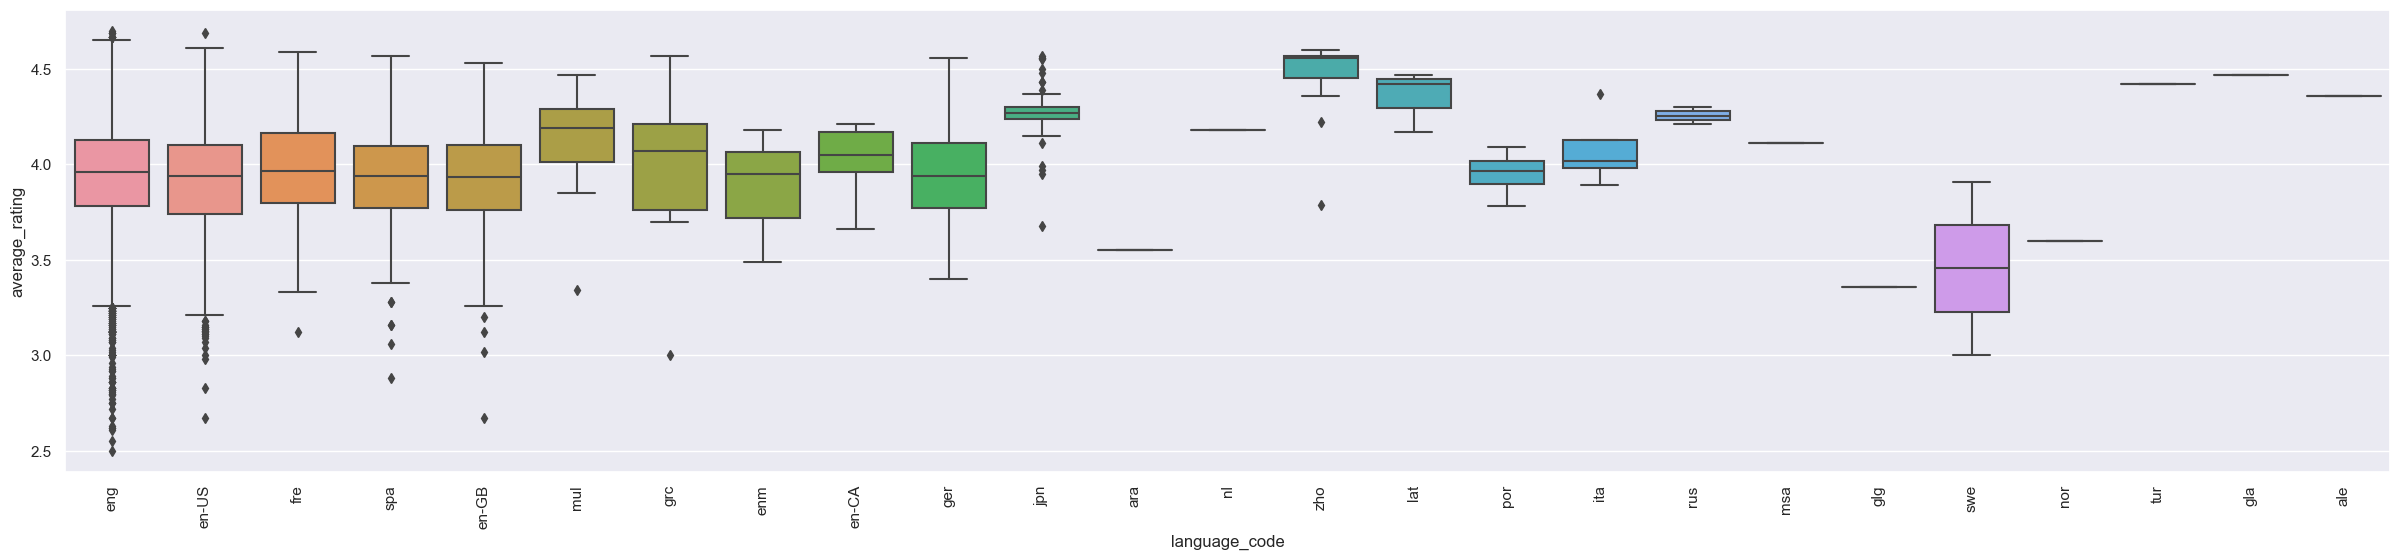

In [38]:
plt.figure(figsize=(30,6))
ax=sns.boxplot(data=books, x='language_code', y='average_rating')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

##### Relation entre language_code et average_rating

#### TEST DE LEVENE

In [39]:
grouped_data = []

# Groupes distincts basés sur les codes de langue
for language_code, group in books.groupby('language_code'):
    grouped_data.append(group['average_rating'])

# Appliquer le test de Levene
levene_test = levene(*grouped_data)
print("P-valeur de Levene :", levene_test.pvalue)

P-valeur de Levene : 8.870848464275683e-05


Le test de Levene nous donne une p-valeur < 0.05, nous pouvons donc conclure que les variances des groupes de language_code ne sont pas homogènes. Nous ne pouvons pas appliquer le test de l'ANOVA dans ce cas.

#### TEST DE KRUSKAL-WALLIS

In [40]:
kruskal_result = kruskal(*grouped_data)

print("P-valeur de Kruskal-Wallis :", kruskal_result.pvalue)

P-valeur de Kruskal-Wallis : 9.717583865672905e-22


Le test de Kruskal-Wallis nous donne une p-valeur < 0.05, nous pouvons donc conclure qu'il existe des différences significatives entre au moins l'une des distributions de groupe. Du coup, nous pouvons affirmer qu'il existe une corrélation entre language_code et average_rating.

##### Relation entre publisher et average_rating

#### TEST DE LEVENE

In [41]:
grouped_data = []

# Groupes distincts basés sur les codes de langue
for language_code, group in books.groupby('publisher'):
    grouped_data.append(group['average_rating'])

# Appliquer le test de Levene
levene_test = levene(*grouped_data)
print("P-valeur de Levene :", levene_test.pvalue)

P-valeur de Levene : 1.7536443043297847e-08


Le test de Levene nous donne une p-valeur < 0.05, nous pouvons donc conclure que les variances des groupes de publisher ne sont pas homogènes. Nous ne pouvons pas appliquer le test de l'ANOVA dans ce cas.

#### TEST DE KRUSKAL-WALLIS

In [42]:
kruskal_result = kruskal(*grouped_data)

print("P-valeur de Kruskal-Wallis :", kruskal_result.pvalue)

P-valeur de Kruskal-Wallis : 2.1847606225631014e-66


Le test de Kruskal-Wallis nous donne une p-valeur < 0.05, nous pouvons donc conclure qu'il existe des différences significatives entre au moins l'une des distributions de groupe. Du coup, nous pouvons affirmer qu'il existe une corrélation entre average_rating et publisher.

##### Relation entre Year et average_rating

#### TEST DE LEVENE

In [43]:
grouped_data = []

# Groupes distincts basés sur les codes de langue
for language_code, group in books.groupby('Year'):
    grouped_data.append(group['average_rating'])

# Appliquer le test de Levene
levene_test = levene(*grouped_data)
print("P-valeur de Levene :", levene_test.pvalue)

P-valeur de Levene : 0.12451225001697351


Le test de Levene nous donne une p-valeur > 0.05, nous pouvons donc conclure que les variances des groupes de Year sont homogènes. Nous pouvons appliquer le test de l'ANOVA dans ce cas.

#### TEST DE L'ANOVA

In [44]:
model = ols('average_rating ~  C(Year)', data=books).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

statistic_f = anova_results['F']['C(Year)']
p_value = anova_results['PR(>F)']['C(Year)']

print("P-valeur de l'ANOVA :", p_value)

P-valeur de l'ANOVA : 0.0006372907568612949


Le test de l'ANOVA nous donne une p-valeur < 0.05, cela suggère qu'au moins une des moyennes diffère de manière significative des autres. Du coup, nous pouvons affirmer qu'il existe une corrélation entre average_rating et Year.

##### Relation entre title et average_rating

#### TEST DE LEVENE

In [45]:
grouped_data = []

# Groupes distincts basés sur les codes de langue
for language_code, group in books.groupby('title'):
    grouped_data.append(group['average_rating'])

# Appliquer le test de Levene
levene_test = levene(*grouped_data)
print("P-valeur de Levene :", levene_test.pvalue)

P-valeur de Levene : 0.9999999999999999


Le test de Levene nous donne une p-valeur > 0.05, nous pouvons donc conclure que les variances des groupes de title sont homogènes. Nous pouvons appliquer le test de l'ANOVA dans ce cas.

##### Relation entre author et average_rating

#### TEST DE LEVENE

In [46]:
grouped_data = []

# Groupes distincts basés sur les codes de langue
for language_code, group in books_df.groupby('authors'):
    grouped_data.append(group['average_rating'])

# Appliquer le test de Levene
levene_test = levene(*grouped_data)
print("P-valeur de Levene :", levene_test.pvalue)

P-valeur de Levene : 0.9999999999999999


Le test de Levene nous donne une p-valeur > 0.05, nous pouvons donc conclure que les variances des groupes de authors sont homogènes. Nous pouvons appliquer le test de l'ANOVA dans ce cas.

## Prédiction de la variable cible

### Choix des variables explicatives

Nous avons décidé de sélectionner comme variables explicatives les variables suivantes :
- title : le titre du livre ;
- authors : le/les auteurs du livre ;
- language_code : la langue d'édition du livre ;
- publisher : le/les éditeurs du livre.
- num_pages : le nombre de pages.

En effet ces variables nous semblent pertinentes et cohérentes pour la prédiction de la variable cible average_rating.

### Choix des métriques d'évaluation

Les métriques que nous avons décidé de considérer pour l'évaluation de la performance de chaque modèle sont :
- Le score R2 ;
- La MSE (Erreur quadratique moyenne).

En effet ces métriques permettent de comparer efficacement des modèles dans le cas d'un problème de régression.

### Encodage des variables catégorielles

In [50]:
encoder = LabelEncoder()
books_df.title = encoder.fit_transform(books_df.title)
books_df.authors = encoder.fit_transform(books_df.authors)
books_df.language_code=encoder.fit_transform(books_df.language_code)
books_df.publisher=encoder.fit_transform(books_df.publisher)

### Division du jeu de données

In [51]:
books_ai = books_df[['title', 'authors', 'language_code', 'num_pages', 'average_rating', 'publisher']]
data = books_ai.drop(['average_rating'], axis=1)
target = books_ai.average_rating
X_train, X_test, y_train, y_test = train_test_split (data, target,
                                                    test_size = 0.2 ,
                                                    random_state = 42)

In [52]:
k_fold = list(KFold(n_splits=5, shuffle=True).split(X_train, y_train))

In [53]:
def grid_search_best_model(model, params, k_fold, X_train, y_train):
    grid_search = GridSearchCV(model,
                           params,                             
                          cv=k_fold).fit(X_train,y_train)
    print("Best params", grid_search.best_params_)
    print("Best estimator", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [54]:
model_results = {}

def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
    y_pred = model.predict(X_test)  
    print(f"Training score: {model.score(X_train,y_train)}")
    print(f"Test score: {r2_score(y_test, y_pred)}")
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
    if show_plot == True:
        predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
    print(predictions_comparision.sample(10))    
    
    
    return {
        "training_score": model.score(X_train,y_train),
        "test_score_r2" : r2_score(y_test, y_pred),
        "test_score_mse" : mean_squared_error(y_test, y_pred)
    }

def compare_results():
    for key in model_results:
        print("Regression: ", key)
        print("Trainign score", model_results[key]["training_score"])
        print("R2 Test score ", model_results[key]["test_score_r2"])
        print("MSE Test score ", model_results[key]["test_score_mse"])
        print()

### Linear Regression

Best params {'fit_intercept': True}
Best estimator LinearRegression()
Best score: 0.02843001577791715
Training score: 0.02991793900759665
Test score: 0.026202315451283154
MSE:  0.07809483505105208
      Actual  Predicted
44      3.97   3.965654
1113    3.88   3.959142
441     4.22   3.919518
929     3.87   3.927263
688     3.62   3.892353
1218    3.75   3.859021
96      3.88   3.989978
859     4.09   3.902992
1658    3.64   3.889341
959     4.04   3.921943


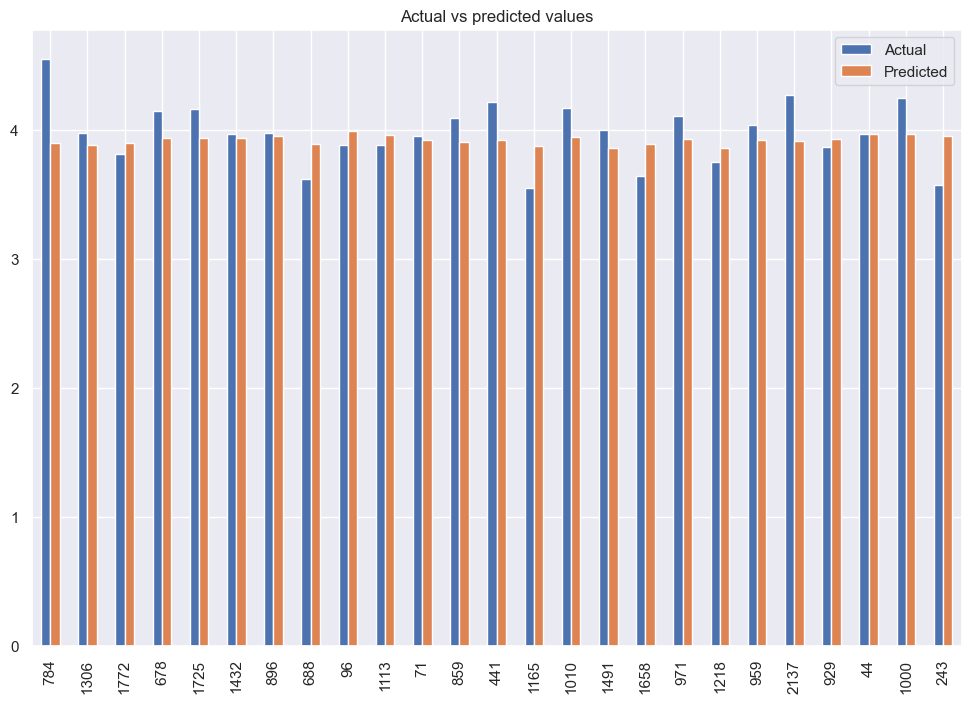

In [55]:
params={
    "fit_intercept":[True,False],
}

linear_regression = grid_search_best_model(LinearRegression(), params, k_fold, X_train, y_train)
model_results["linear_regression"] = score_model(linear_regression, X_train, X_test, y_train, y_test)

### K-Neighbors Regressor

Best params {'leaf_size': 30, 'n_neighbors': 24}
Best estimator KNeighborsRegressor(n_neighbors=24)
Best score: 0.008764970760893775
Training score: 0.09254968596454916
Test score: 0.011390108423623313
MSE:  0.07928271717782383
      Actual  Predicted
157     3.81   3.960417
727     3.90   3.925000
795     4.08   3.995833
259     3.55   3.913333
2136    3.78   3.970833
2112    3.63   3.915833
1455    4.21   3.883750
382     3.79   4.063333
198     3.99   3.873750
439     4.22   3.976250


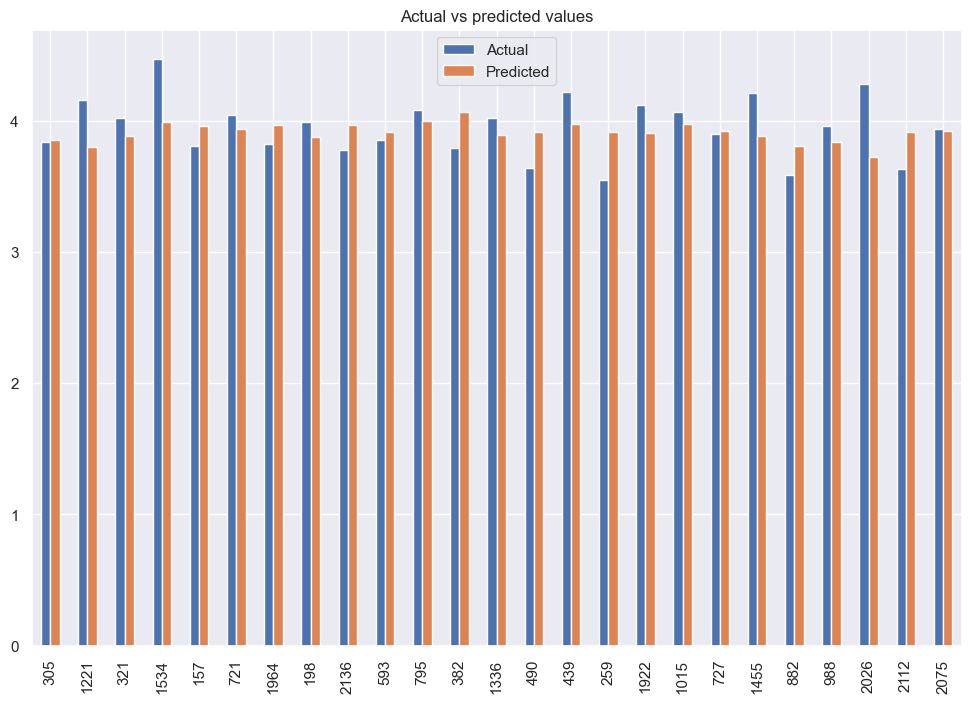

In [56]:
params={
    "n_neighbors": range(2, 30),
    "leaf_size":[20,30,50,70]
}

knn = grid_search_best_model(KNeighborsRegressor(), params, k_fold, X_train, y_train)
model_results["knn"] = score_model(knn, X_train, X_test, y_train, y_test)

### Decision Tree Regressor

Best params {'max_depth': 50, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best estimator DecisionTreeRegressor(max_depth=50, max_leaf_nodes=20, min_samples_leaf=5,
                      min_samples_split=20)
Best score: 0.07820980781014471
Training score: 0.10139539471968606
Test score: 0.05854391350212296
MSE:  0.07550116307468234
      Actual  Predicted
1308    4.28   3.898950
1679    4.02   3.898950
777     4.11   4.115455
1156    4.05   3.898950
11      4.11   4.004211
1526    3.69   3.898950
1899    4.26   4.205185
1232    3.96   3.898950
1939    3.93   3.948821
165     4.47   3.995860


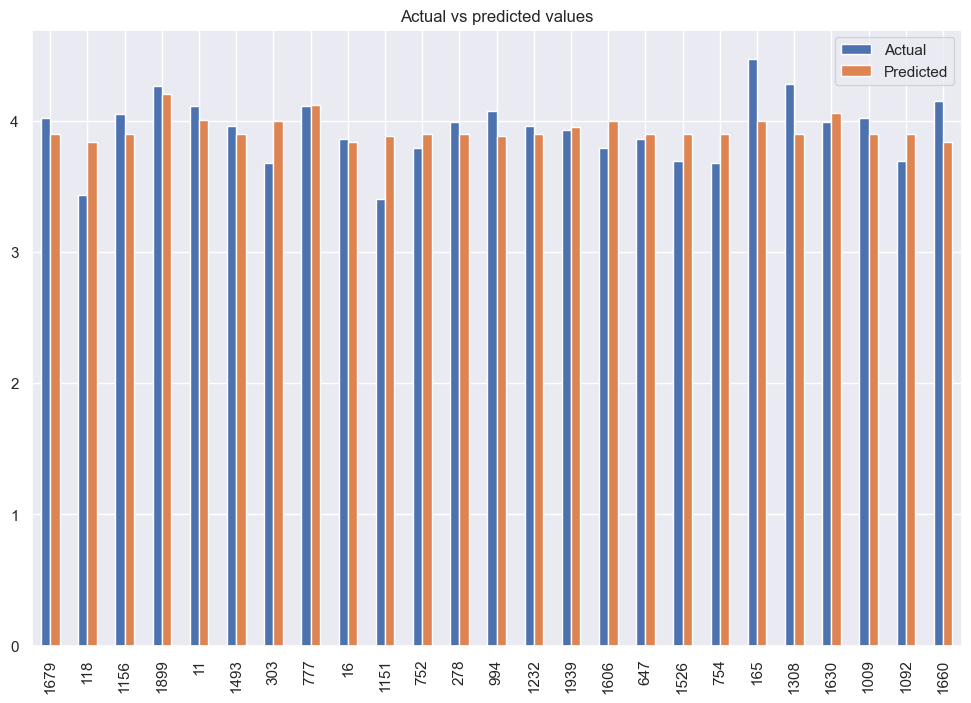

In [57]:
params = {    "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 15, 50],
              "min_samples_leaf": [5, 20, 30],
              "max_leaf_nodes": [5, 20],
              }
dtr = grid_search_best_model(DecisionTreeRegressor(), params, k_fold, X_train, y_train)
model_results["dtr"] = score_model(dtr, X_train, X_test, y_train, y_test)

### Ada Boost Regressor

Best params {'learning_rate': 0.3, 'n_estimators': 1000}
Best estimator AdaBoostRegressor(learning_rate=0.3, n_estimators=1000)
Best score: 0.004820363266337657
Training score: 0.024623359189007377
Test score: -0.006296914616257476
MSE:  0.08070114850987589
      Actual  Predicted
2141    3.91   3.847593
1298    3.93   3.808485
469     3.95   3.839989
101     4.10   3.849148
61      3.71   3.808485
452     3.51   3.905190
495     4.19   3.847593
919     4.12   3.882064
1489    3.98   3.839989
334     3.57   3.847593


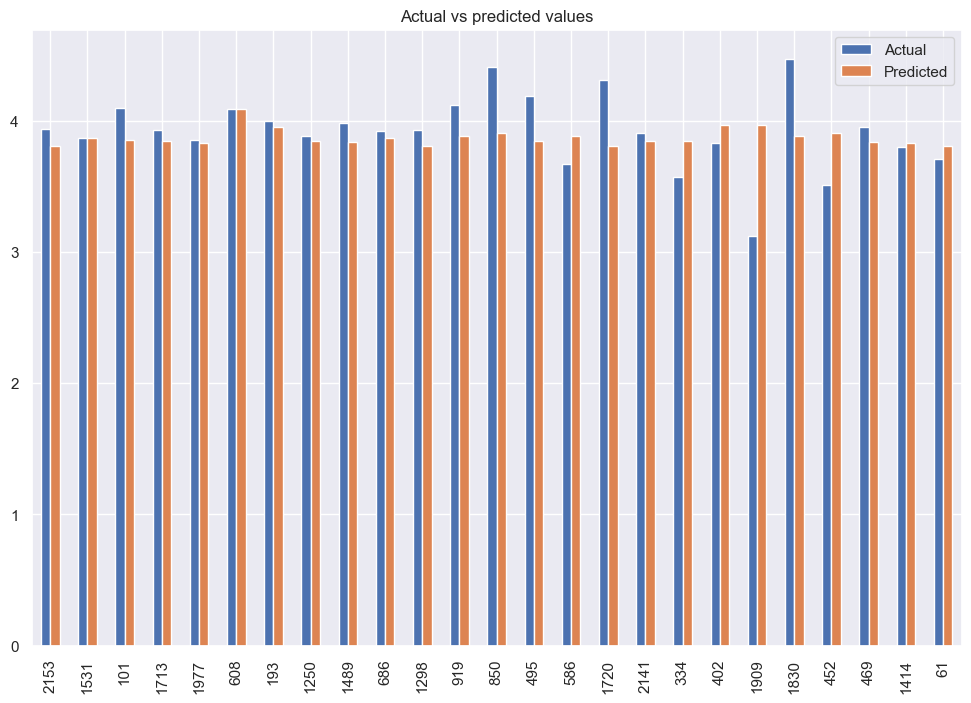

In [58]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400,700,1000]
              }
abr = grid_search_best_model(AdaBoostRegressor(), params, k_fold, X_train, y_train)
model_results["abr"] = score_model(abr, X_train, X_test, y_train, y_test)

### Linear Support Vector Regression

Best params {'C': 5000, 'fit_intercept': False}
Best estimator LinearSVR(C=5000, fit_intercept=False)
Best score: -17.67831075822412
Training score: -329.46877096939284
Test score: -324.849073417332
MSE:  26.131844472250485
      Actual  Predicted
1223    4.21   6.840945
388     3.72  11.254022
1839    3.70   5.634724
1151    3.40   8.002204
1606    3.79   6.446172
955     4.04   4.697618
305     3.84   5.602268
1894    3.87   5.687630
743     4.50   8.999395
1536    4.06  11.961560


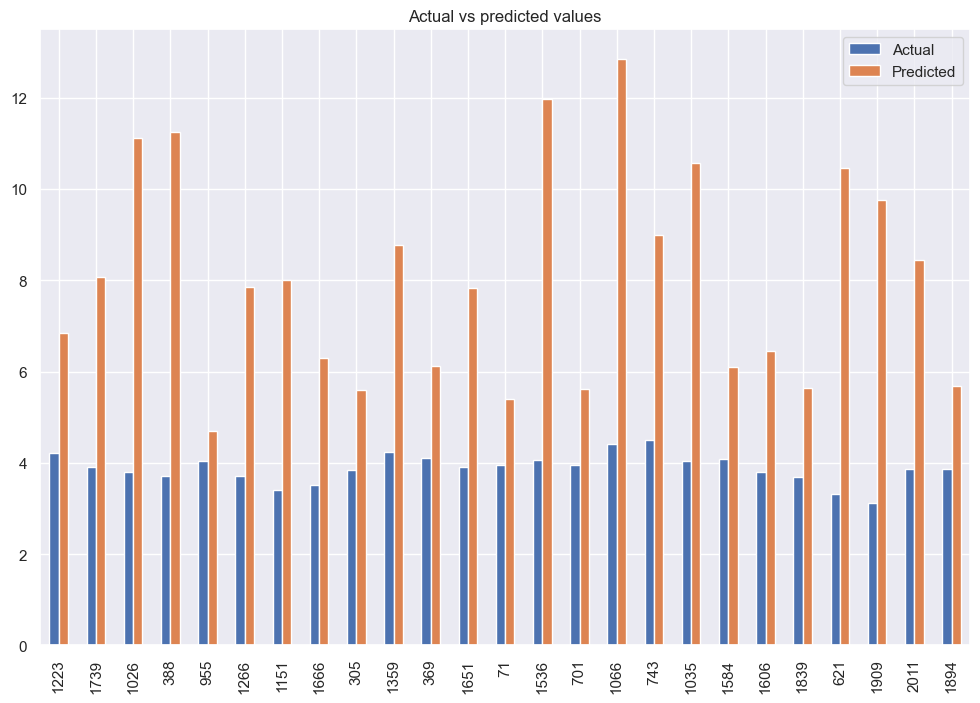

In [59]:
params = {
  "C": [0.1,1, 5, 10, 150,500,1000,5000],
    "fit_intercept":[True,False]
}
linear_svr = grid_search_best_model(LinearSVR(), params,k_fold, X_train, y_train)
model_results["linear_svr"] = score_model(linear_svr, X_train, X_test, y_train, y_test)

### Gradient Boosting Regressor

Best params {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 200}
Best estimator GradientBoostingRegressor(learning_rate=0.05, max_depth=10, max_features=0.3,
                          min_samples_leaf=3, n_estimators=200)
Best score: 0.1275998680432261
Training score: 0.6168701451372536
Test score: 0.14080816532186247
MSE:  0.06890388596220079
      Actual  Predicted
2144    4.12   4.080734
1401    4.18   3.892617
347     3.68   3.937241
273     4.35   3.816387
433     3.73   3.976173
1484    4.04   3.918951
1150    4.31   3.898956
1504    3.87   4.109189
369     4.11   3.950099
1842    4.10   4.076960


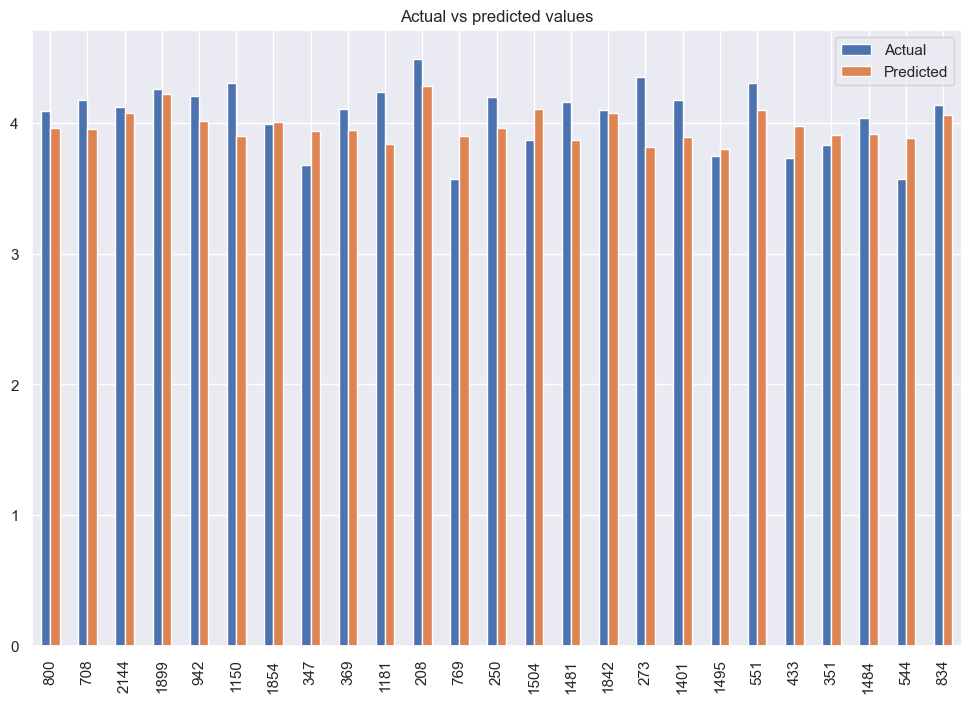

In [60]:
params={"n_estimators":[20, 50, 100,200], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
          "max_features": [0.3, 1]
       }        

gbr = grid_search_best_model(GradientBoostingRegressor(), params,k_fold, X_train, y_train)
model_results["gbr"] = score_model(gbr, X_train, X_test, y_train, y_test)

### Gaussian Support Vector Regression

Best params {'C': 1, 'epsilon': 0.01, 'gamma': 0.001}
Best estimator SVR(C=1, epsilon=0.01, gamma=0.001)
Best score: 0.05831768974710112
Training score: 0.9940965212204338
Test score: 0.05962002997810556
MSE:  0.07541486266544843
      Actual  Predicted
1822    3.69   3.933372
1964    3.82   3.933372
1333    3.81   3.933372
833     4.12   3.933372
855     4.31   3.933372
1794    3.56   3.570598
599     4.29   4.288423
1967    4.00   3.933372
994     4.07   3.933372
1992    4.22   3.933372


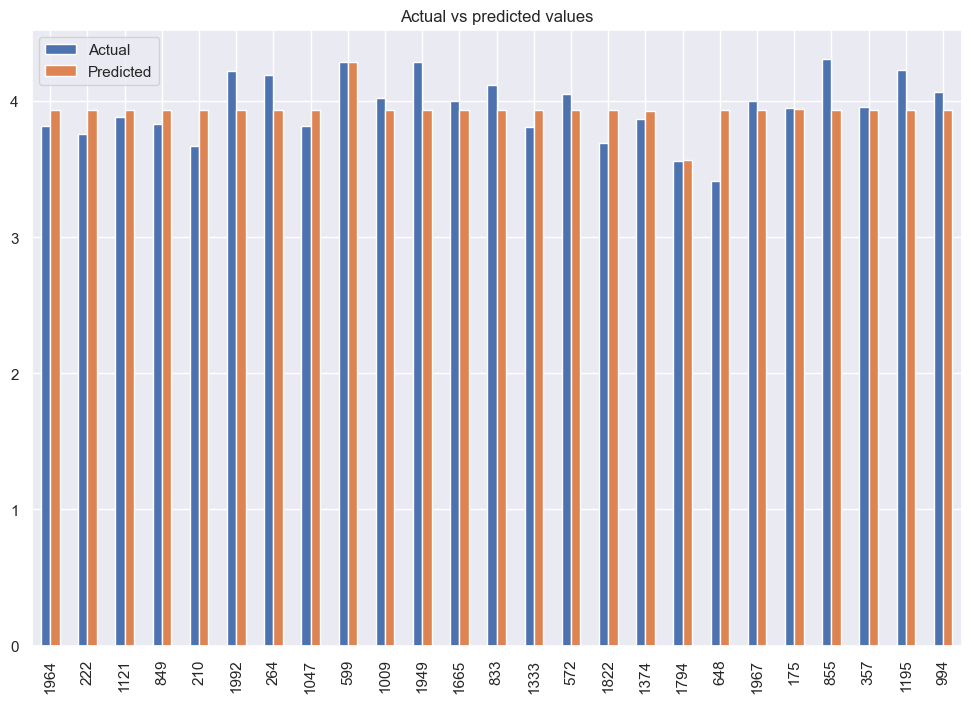

In [61]:
params = { 
    "C": [1, 5, 50, 100],
    "gamma": [0.001, 0.01, 0.1],
    "epsilon" : [0.01, 0.1]
}

gaussian_svr = grid_search_best_model(SVR(), params, k_fold,X_train, y_train)
model_results["gaussian_svr"] = score_model(gaussian_svr, X_train, X_test, y_train, y_test)

In [62]:
compare_results()

Regression:  linear_regression
Trainign score 0.02991793900759665
R2 Test score  0.026202315451283154
MSE Test score  0.07809483505105208

Regression:  knn
Trainign score 0.09254968596454916
R2 Test score  0.011390108423623313
MSE Test score  0.07928271717782383

Regression:  dtr
Trainign score 0.10139539471968606
R2 Test score  0.05854391350212296
MSE Test score  0.07550116307468234

Regression:  abr
Trainign score 0.024623359189007377
R2 Test score  -0.006296914616257476
MSE Test score  0.08070114850987589

Regression:  linear_svr
Trainign score -329.46877096939284
R2 Test score  -324.849073417332
MSE Test score  26.131844472250485

Regression:  gbr
Trainign score 0.6168701451372536
R2 Test score  0.14080816532186247
MSE Test score  0.06890388596220079

Regression:  gaussian_svr
Trainign score 0.9940965212204338
R2 Test score  0.05962002997810556
MSE Test score  0.07541486266544843



### Conclusion

Il ressort des résultats fournis par les différents modèles de régression les remarques :
- Le score R2 est très mauvais < 1% ;
- L'erreur quadratique moyenne (MSE) est significvative ;
- Le modèle gbr, correspondant au Gradient Boosting Regressor fourni l'erreur quadratique moyenne la moins importante.